# Prediction of surgery vs non-sergery using taxonomy profile

Train machine learning models on sepecies abundance to predict if the sample is from a patient tha has undergone surgery

In [1]:
import numpy as np 
import biom
import pandas as pd 
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
#load species abundance 

df_species=pd.read_csv('./data/metaphlan2_species_level_abundance_classified.csv',index_col=0)
df_meta=pd.read_csv('./data/metadata_updated_filtered_201904.csv',index_col=0)

#create dictionary to 
dic_date=dict(zip(list(df_meta.index),list(df_meta.time_point)))
dic_surgery=dict(zip(list(df_meta.index),list(df_meta.surgery_type)))

In [3]:
## only train the model on bacteria 
species_keep=[]
for i in df_species.index: 
    if not 'virus' in i and not 'Archaea'in i:
        species_keep.append(i)
df_species=df_species.loc[species_keep]     
df_species.shape

(428, 301)

## RandomForest classifier for 2 groups: surgery vs no surgery

### Split approach: Separates by subjects
make sure subject in training data does not overlap with subjects in test data


In [4]:
from random import sample 
#organize subjects and samples, and record their surgery status
dic_subject=dict(zip(list(df_meta.host_id),list(df_meta.surgery_type)))
dic_sample_host=dict(zip(list(df_meta.index),list(df_meta.host_id)))
subject_nonsurgery=[i for i in dic_subject.keys() if dic_subject[i]=='none']
subject_surgery=[i for i in dic_subject.keys() if i not in subject_nonsurgery]

# write a function to randomly split test and training set, so that the subjects in test and training do not overlap 
# 70% percent of the subjects are in training samples while 30% subjects are in test samples
def split_data(df_meta,df_species):
    #use randome sample to select ~70% subject from each group as training data 
    sub_train_nosurg=sample(subject_nonsurgery,int(len(subject_nonsurgery)*0.7))
    sub_train_surg=sample(subject_surgery,int(len(subject_surgery)*0.7))
    sub_train=sub_train_nosurg+sub_train_surg

    #map subjects back to samples and build the training dataset 
    sample_train=[i for i in df_species.columns if dic_sample_host[i] in sub_train]
    sample_test=[i for i in df_species.columns if i not in sample_train]
    X_train=df_species[sample_train]
    X_test=df_species[sample_test]
    
    ## create the output 
    y_train=[]
    for i in X_train.columns: 
        if dic_surgery[i]=='none': 
            y_train.append(0)
        else: 
            y_train.append(1)

    y_test=[]
    for i in X_test.columns: 
        if dic_surgery[i]=='none': 
            y_test.append(0)
        else: 
            y_test.append(1)
    return X_train, X_test,y_test,y_train

X_train, X_test,y_test,y_train=split_data(df_meta,df_species)

### Train and test the model

In [5]:
#train regressor and run it on test data 
from sklearn.ensemble import RandomForestClassifier
class_rf = RandomForestClassifier(n_jobs=4)
class_rf.fit(X_train.T, y_train)

# 10-fold cross validation on the test data 
from sklearn.cross_validation import cross_val_score
scores = cross_val_score(class_rf, X_train.T, y_train, cv=10)
print 'cross-validation on the training data: '
print scores

# Predict on new data
y_rf = class_rf.predict(X_test.T)

# calculate the accuracy score of the classifier 
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score

print 'Prediction accuracy score on the test data: ', accuracy_score(y_test, y_rf) 
average_precision=average_precision_score(y_test, y_rf) 
print 'Average precision-recall score: ', average_precision

/usr/local/lib/python2.7/dist-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


cross-validation on the training data: 
[0.9047619  0.85714286 0.95       0.75       0.85       0.89473684
 0.78947368 0.89473684 0.84210526 0.78947368]
Prediction accuracy score on the test data:  0.8846153846153846
Average precision-recall score:  0.8307692307692308


## Randomly split data, train and test the model for 100 times 
### Record ad calculate the average precision-recall score 
### identify the most important species that had the highest occurance

In [7]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score

#define classifier 
from sklearn.ensemble import RandomForestClassifier
class_rf = RandomForestClassifier(n_jobs=4)
y_test_all=[]
y_rf_all=[]
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
pcscore_list=[]
featuelist=[]
for i in range(100): 
    print i 
    X_train, X_test,y_test,y_train=split_data(df_meta,df_species)
    class_rf.fit(X_train.T, y_train)
    # Predict on new data
    y_rf = class_rf.predict(X_test.T)
    #record the y_test and y_rf for each iteration so it could be used to calculate over all precision-recall curve
    y_test_all.append(y_test)
    y_rf_all.append(y_rf)
    # calculate the accuracy score of the classifier 
    pcscore_list.append(average_precision_score(y_test, y_rf))
    ind_top30=sorted(range(len(class_rf.feature_importances_)), key=lambda i: class_rf.feature_importances_[i])[-30:]
    for i in ind_top30: 
        featuelist.append(df_species.index[i])
    probas_= class_rf.fit(X_train.T, y_train).predict_proba(X_test.T)
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)


0


KeyboardInterrupt: 

In [96]:
# count the most important features that overlapped in 100 runs 
dic_count={}
for s in set(featuelist): 
    count=featuelist.count(s)
    dic_count[s]=count
dic_count

import operator
sorted_x = sorted(dic_count.items(), key=operator.itemgetter(1))
sorted_x

[('k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_coprocola',
  1),
 ('k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_raffinosus',
  1),
 ('k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Gardnerella|s__Gardnerella_vaginalis',
  1),
 ('k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Parascardovia|s__Parascardovia_denticolens',
  1),
 ('k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Leuconostocaceae|g__Leuconostoc|s__Leuconostoc_mesenteroides',
  1),
 ('k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_sanguinis',
  1),
 ('k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_oralis',
  1),
 ('k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__St

### Precision-recall curve

In [6]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.utils.fixes import signature

#flat the list 
y_test_all_flat = [item for sublist in y_test_all for item in sublist]
y_rf_all_flat = [item for sublist in y_rf_all for item in sublist]

precision, recall, _ = precision_recall_curve(y_test_all_flat, y_rf_all_flat)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.3,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))
#plt.savefig('../data/Sandborn_data/figures/precision_recall_curve_species.pdf')

NameError: name 'y_test_all' is not defined

### Compute ROC curve and area under the curve

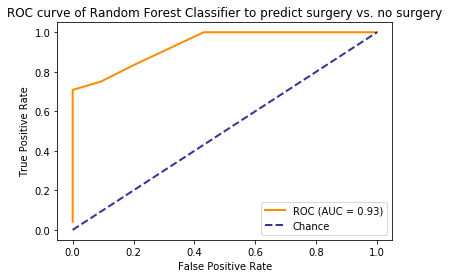

In [7]:
#plot the average AUC ROC for 100 iterations 
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='darkorange',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='navy',
         label='Chance', alpha=.8)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Random Forest Classifier to predict surgery vs. no surgery')
plt.legend(loc="lower right")
plt.show()
#plt.savefig('../data/Sandborn_data/figures/AUC_ROC_100_iterations_taxonomy_classification.svg')
#plt.savefig('../data/Sandborn_data/figures/AUC_ROC_100_iterations_taxonomy_classification.pdf')